## Weakly Supervised Localization : Class Activation map for caltech 101
간단한 CNN (Global Average Pooling)을 caltech 101 데이터에 대해서 학습하고 임의의 caltech 101 데이터 중 하나를 예측하고 Class Activation Map을 그리는 예제, 이 때 단순화를 위해서 caltech 101 데이터중 13개의 class만 활용, **최성준 박사과정**의 아래의 코드를 참고하였음.  

구조 : Conv-Conv-Max_pool-Conv-Conv-Global_average_pool-fully_connected  
참고 코드 : https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/gap_mnist.ipynb  
논문 : http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

### Load modules

In [1]:
import os, sys
import numpy as np
import scipy.misc
import scipy.io
import tensorflow as tf
import re
import matplotlib.pyplot as plt
%matplotlib inline

### Load CALTECH 101

In [2]:
os.getcwd()

'D:\\dev'

In [3]:
os.chdir('./CNN')
cwd = os.getcwd()
path = cwd + "/101_ObjectCategories"

In [4]:
cwd = os.getcwd()
path = cwd + "/101_ObjectCategories"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print("[%d] CATEGORIES ARE IN" % (len(list(filter(lambda x : x.find('a') == 0 or x.find('b') == 0 , os.listdir(path))))))

categories = list(filter(lambda x : x.find('a') == 0 or x.find('b') == 0 , os.listdir(path)))
ncategories = len(categories)
imgs = []
labels = []

[13] CATEGORIES ARE IN


In [5]:
categories

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly']

In [6]:
# Define user function
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))

In [7]:
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    if i == 0:
        continue
    for f in os.listdir(path + "/" + category):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_exts:
            continue
        fullpath = os.path.join(path + "/" + category, f)
        img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
        imgs.append(img) # NORMALIZE IMAGE 
        label_curr = np.zeros((ncategories))
        label_curr[i] = 1
        labels.append(label_curr)
print ("Num imgs: %d" % (len(imgs)))
print ("Num labels: %d" % (len(labels)) )

Num imgs: 1509
Num labels: 1509


In [8]:
imgs = np.asarray(imgs)
labels = np.asarray(labels)
print(imgs.shape, labels.shape)

# split my dataset
tr_index = np.random.choice(np.arange(imgs.shape[0]), size = 1450, replace = False)
tr_imgs_merged = imgs[tr_index]
tr_labels_merged = labels[tr_index]

val_index = np.random.choice(np.arange(tr_imgs_merged.shape[0]), size = 50, replace = False)
val_imgs = tr_imgs_merged[val_index]
val_labels = tr_labels_merged[val_index]

tr_imgs = np.delete(tr_imgs_merged, val_index, axis = 0)
tr_labels = np.delete(tr_labels_merged, val_index , axis = 0)

ts_imgs = np.delete(imgs, tr_index, axis = 0)
ts_labels = np.delete(labels, tr_index, axis = 0)

print('training', tr_imgs.shape, tr_labels.shape)
print('validation',val_imgs.shape, val_labels.shape)
print('test', ts_imgs.shape, ts_labels.shape)

(1509, 224, 224, 3) (1509, 13)
training (1400, 224, 224, 3) (1400, 13)
validation (50, 224, 224, 3) (50, 13)
test (59, 224, 224, 3) (59, 13)


In [9]:
# Graph parameters
weights = {
    'w1' : tf.get_variable(name = 'weight1', shape = [3,3,3,32], initializer = tf.contrib.layers.variance_scaling_initializer()), 
    'w2' : tf.get_variable(name = 'weight2', shape = [3,3,32,64], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w3' : tf.get_variable(name = 'weight3', shape = [3,3,64,96], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w4' : tf.get_variable(name = 'weight4', shape = [3,3,96,128], initializer = tf.contrib.layers.variance_scaling_initializer()),
    'w5' : tf.get_variable(name = 'weight5', shape = [128, 13], initializer = tf.contrib.layers.xavier_initializer())
}

bias = {
    'b1' : tf.get_variable(name = 'bias1', shape = [32], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b2' : tf.get_variable(name = 'bias2', shape = [64], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b3' : tf.get_variable(name = 'bias3', shape = [96], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b4' : tf.get_variable(name = 'bias4', shape = [128], initializer = tf.random_uniform_initializer(minval = 0.001, maxval = 1)),
    'b5' : tf.get_variable(name = 'bias5', shape = [13], initializer = tf.random_normal_initializer())
}

In [10]:
def my_CNN(X, Y, weights, bias):

    #conv_1
    conv1 = tf.nn.conv2d(input = X, filter = weights['w1'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation1 = conv1 + bias['b1']
    print(pre_activation1)
    relu1 = tf.nn.relu(features = pre_activation1)

    #conv_2
    conv2 = tf.nn.conv2d(input = relu1, filter = weights['w2'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation2 = conv2 + bias['b2']
    print(pre_activation2)
    relu2 = tf.nn.relu(features = pre_activation2)

    #Max_pool
    pooled = tf.nn.max_pool(value = relu2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    #conv_3
    conv3 = tf.nn.conv2d(input = pooled, filter = weights['w3'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation3 = conv3 + bias['b3']
    print(pre_activation3)
    relu3 = tf.nn.relu(features = pre_activation3)
    
    #conv_4
    conv4 = tf.nn.conv2d(input = relu3, filter = weights['w4'], strides = [1,1,1,1], padding = 'SAME')
    pre_activation4 = conv4 + bias['b4']
    print(pre_activation4)
    relu4 = tf.nn.relu(features = pre_activation4)

    #GAP
    gap = tf.nn.avg_pool(value = relu4, ksize = [1,112,112,1], strides = [1,112,112,1], padding = 'SAME')
    print(gap)
    gap_dense = tf.reshape(tensor = gap, shape = [-1,128])
    print(gap_dense)

    #fully_connected
    score = tf.matmul(gap_dense, weights['w5']) + bias['b5']
    print(score)
    
    out = {
        'Ximg' : X, 'conv1' : relu1, 'conv2' : relu2, 'Max_pool' : pooled, 'conv3' : relu3, 'conv4' : relu4,
        'gap' : gap, 'gap_dense' : gap_dense, 'score' : score
    }
    
    return out
   
# define function    
X = tf.placeholder(dtype = tf.float32, shape = [None, 224, 224, 3])
Y = tf.placeholder(dtype = tf.float32, shape = [None, 13])
out = my_CNN(X, Y, weights, bias)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = out['score']))
train = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
is_correct = tf.cast(tf.equal(tf.argmax(out['score'], axis = 1), tf.argmax(Y, axis = 1)), dtype = tf.float32)
accuracy = tf.reduce_mean(is_correct)

Tensor("add:0", shape=(?, 224, 224, 32), dtype=float32)
Tensor("add_1:0", shape=(?, 224, 224, 64), dtype=float32)
Tensor("add_2:0", shape=(?, 112, 112, 96), dtype=float32)
Tensor("add_3:0", shape=(?, 112, 112, 128), dtype=float32)
Tensor("AvgPool:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("Reshape:0", shape=(?, 128), dtype=float32)
Tensor("add_4:0", shape=(?, 13), dtype=float32)


In [11]:
# hyperparameter
batch_size = 50
epochs = 30

# train
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(epochs):
    total_batch = int(imgs.shape[0] / batch_size)
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_batch):
        index = np.random.choice(np.arange(tr_imgs.shape[0]), size = batch_size, replace = False)
        batch_xs = tr_imgs[index]
        batch_ys = tr_labels[index]
        tr_loss, _ = sess.run([loss, train], feed_dict = {X : batch_xs, Y : batch_ys})
        val_loss = sess.run(loss, feed_dict = {X: val_imgs, Y : val_labels})
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
    print('epoch : {:2}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))

epoch :  0, tr_loss : 76.278, val_loss : 52.488
epoch :  1, tr_loss : 4.043, val_loss : 3.870
epoch :  2, tr_loss : 1.637, val_loss : 1.886
epoch :  3, tr_loss : 1.371, val_loss : 1.658
epoch :  4, tr_loss : 1.245, val_loss : 1.521
epoch :  5, tr_loss : 1.180, val_loss : 1.633
epoch :  6, tr_loss : 1.160, val_loss : 1.543
epoch :  7, tr_loss : 1.153, val_loss : 1.510
epoch :  8, tr_loss : 1.083, val_loss : 1.440
epoch :  9, tr_loss : 1.006, val_loss : 1.466
epoch : 10, tr_loss : 1.008, val_loss : 1.334
epoch : 11, tr_loss : 1.009, val_loss : 1.359
epoch : 12, tr_loss : 0.887, val_loss : 1.310
epoch : 13, tr_loss : 0.924, val_loss : 1.373
epoch : 14, tr_loss : 0.927, val_loss : 1.349
epoch : 15, tr_loss : 0.880, val_loss : 1.364
epoch : 16, tr_loss : 0.808, val_loss : 1.254
epoch : 17, tr_loss : 0.802, val_loss : 1.323
epoch : 18, tr_loss : 0.724, val_loss : 1.341
epoch : 19, tr_loss : 0.809, val_loss : 1.295
epoch : 20, tr_loss : 0.708, val_loss : 1.380
epoch : 21, tr_loss : 0.650, val

In [12]:
# test accuracy
sess.run(accuracy, feed_dict = {X : ts_imgs, Y : ts_labels})

0.79661018

### Class Activation Map 

In [13]:
# Class Activation Map
num = np.random.randint(0, ts_imgs.shape[0])
out = sess.run(my_CNN(X, Y, weights, bias), feed_dict = {X : ts_imgs[num].reshape(1,224,224,3)})

Tensor("add_5:0", shape=(?, 224, 224, 32), dtype=float32)
Tensor("add_6:0", shape=(?, 224, 224, 64), dtype=float32)
Tensor("add_7:0", shape=(?, 112, 112, 96), dtype=float32)
Tensor("add_8:0", shape=(?, 112, 112, 128), dtype=float32)
Tensor("AvgPool_1:0", shape=(?, 1, 1, 128), dtype=float32)
Tensor("Reshape_4:0", shape=(?, 128), dtype=float32)
Tensor("add_9:0", shape=(?, 13), dtype=float32)


In [14]:
# Run Network 
inputimg = out.get('Ximg')
outval = out.get('score')
outprob = sess.run(tf.nn.softmax(outval))
camval = out.get('conv4')
cweights = sess.run(weights['w5'])

In [15]:
np.argmax(ts_labels[num]) == np.argmax(outprob)

True

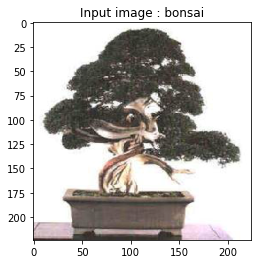

In [16]:
# Plot original Image 
plt.imshow(inputimg.astype(np.uint8)[0])
plt.title("Input image : {}".format(categories[np.argmax(ts_labels[num])]))

In [17]:
# normalization function for Class Activation MAP
def minmax_scaler(arr):
    _arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return _arr    

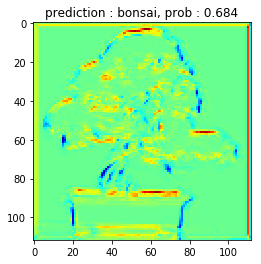

In [18]:
# Plot class activation maps 
predlabel   = np.argmax(outval)
predweights = cweights[:, predlabel]
camsum = np.zeros((112, 112))

for j in range(128):
    camsum = camsum + predweights[j] * camval[0,:,:,j]
    camavg = camsum / 128

plt.imshow(minmax_scaler(camavg), cmap = 'jet')
plt.title('prediction : {}, prob : {:.3f}'.format(categories[np.argmax(outprob)], outprob[0,predlabel]))
#plt.title('{} prob \n is {:.3f}'.format(class_dict.get(str(predlabel)), outprob[0,predlabel]))